# Arbitrum test strategy

- This is BTC-USD trading pair strategy to be run on Uniswap v3 on Arbitrum
- This strategy is referred in documentation

In [3]:
"""
To backtest:


"""
import pandas as pd
import numpy as np
import datetime

import pandas_ta as ta

from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve
from tradeexecutor.analysis.trade_analyser import build_trade_analysis
import logging
from tradeexecutor.analysis.advanced_metrics import (
    visualise_advanced_metrics,
    AdvancedMetricsMode,
)


from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.strategy.reserve_currency import ReserveCurrency
from tradeexecutor.strategy.strategy_type import StrategyType
from tradeexecutor.strategy.trading_strategy_universe import (
    load_pair_data_for_single_exchange,
    TradingStrategyUniverse,
)
from tradeexecutor.strategy.trading_strategy_universe import load_partial_data
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

TRADING_STRATEGY_ENGINE_VERSION = "0.2"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# We trade on Polygon
CHAIN_ID = ChainId.arbitrum

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc_poly

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m5

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Which trading pair we are backtesting on
# (Might be different from the live trading pair)
# https://tradingstrategy.ai/trading-view/polygon/quickswap/eth-usdc
# TRADING_PAIR = [(ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005)]
TRADING_PAIR = (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005)


def plot(state, timestamp, indicators):
    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(
        timestamp,
        "SMA Long",
        PlotKind.technical_indicator_on_price,
        indicators["sma_long"],
        colour="darkblue",
    )
    visualisation.plot_indicator(
        timestamp,
        "SMA Short",
        PlotKind.technical_indicator_on_price,
        indicators["sma_short"],
        colour="darkblue",
    )

    visualisation.plot_indicator(
        timestamp,
        "RSI",
        PlotKind.technical_indicator_detached,
        indicators["rsi"],
        colour="#003300",
    )


ma_long = 112
ma_short = 6
rsi_cutt = 8
atr_distance = 2
# Expected 5.28

#ma_long = 526
#ma_short = 6
#rsi_cutt = 100
#atr_distance = 2


def get_signals(candles):
    close = candles["close"].iloc[-1]
    low = candles["low"].iloc[-1]

    # Calculate indicators
    sma_short = ta.sma(candles["close"], length=ma_short)
    sma_short = ta.sma(candles["close"], length=ma_short).iloc[-1]
    sma_long = ta.sma(candles["close"], length=ma_long).iloc[-1]
    rsi = ta.rsi(candles["close"], length=2).iloc[-1]
    atr = ta.atr(candles["high"], candles["low"], candles["close"], length=14).iloc[-1]

    # Calculate signals

    entry = close <= sma_short and close >= sma_long and rsi <= rsi_cutt
    exit = close > sma_short
    sl = low - atr * atr_distance
    sl_pct = float(round(sl / candles["open"].iloc[-1], 6))

    indicators = {
        "sma_short": sma_short,
        "sma_long": sma_long,
        "rsi": rsi,
        "atr": atr,
    }
    return entry, exit, sl, sl_pct, indicators


def calculate_size(state, close):
    cash = state.portfolio.get_current_cash()
    return cash * 0.99


current_sl = np.inf


def decide_trades(timestamp, universe, state, pricing_model, cycle_debug_data):
    # The pair we are trading
    trades = []
    pair = universe.pairs.get_single()

    candles: pd.DataFrame = universe.candles.get_single_pair_data(
        timestamp, sample_count=ma_long
    )

    if len(candles) < ma_long:
        # Backtest starting.
        # By default get_single_pair_data() returns the candles prior to the `timestamp`,
        # the behavior can be changed with get_single_pair_data(allow_current=True).
        # At the start of the backtest, we do not have any previous candle available yet,
        # so we cannot ask the the close price.
        return trades

    current_price = candles["close"].iloc[-1]

    entry, exit, sl, sl_pct, indicators = get_signals(candles)
    global current_sl

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    buy_amount = calculate_size(state, current_price)

    if not position_manager.is_any_open():
        if entry:
            # print(sl)
            # sl = 0.98
            current_sl = sl
            trades += position_manager.open_1x_long(pair, buy_amount)
            # trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=sl_pct)
    else:
        if exit:
            current_sl = np.inf
            trades += position_manager.close_all()
        # elif current_price < current_sl:
        #     current_sl = np.inf
        #     trades += position_manager.close_all()

    plot(state, timestamp, indicators)

    return trades


# def create_trading_universe(
#     client: Client,
#     trading_pair,
#     start_at,
#     end_at,
#     execution_context,
#     universe_options,
#     reserve_currency,
#     candle_time_bucket=TimeBucket.h4,
#     stop_loss_time_bucket=TimeBucket.h1,
# ) -> TradingStrategyUniverse:
#     assert (
#         not execution_context.mode.is_live_trading()
#     ), f"Only strategy backtesting supported, got {execution_context.mode}"
#
#     # Load data for our trading pair whitelist
#     dataset = load_partial_data(
#         client=client,
#         time_bucket=candle_time_bucket,
#         pairs=trading_pair,
#         execution_context=execution_context,
#         universe_options=universe_options,
#         stop_loss_time_bucket=stop_loss_time_bucket,
#         start_at=start_at,
#         end_at=end_at,
#     )
#
#     # Filter down the dataset to the pairs we specified
#     universe = TradingStrategyUniverse.create_multichain_universe_by_pair_descriptions(
#         dataset,
#         trading_pair,
#         reserve_token_symbol=reserve_currency,
#     )
#
#     return universe
def create_trading_universe(
    ts: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
):
    assert isinstance(
        client, Client
    ), f"Looks like we are not running on the real data. Got: {client}"

    # Download live data from the oracle
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,
        universe_options=universe_options,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

In [4]:
# trading_pair=[
#     (ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005),
#     # (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
# ],
cycle_duration = CycleDuration.cycle_1h
initial_deposit = 10_000
start_at = datetime.datetime(2021, 12, 20)
end_at = datetime.datetime(2023, 8, 15)

reserve_currency = ReserveCurrency.usdc
trade_routing = TradeRouting.uniswap_v3_usdc_poly

client = Client.create_jupyter_client()
universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    ExecutionContext(mode=ExecutionMode.backtesting),
    universe_options=UniverseOptions(),
)

state, _, debug_dump = run_backtest_inline(
    name="SLS",
    start_at=start_at,
    end_at=end_at,
    client=client,
    cycle_duration=cycle_duration,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=initial_deposit,
    reserve_currency=reserve_currency,
    trade_routing=trade_routing,
    log_level=logging.WARNING,
)



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


Loading OHLCV data for 42161-uniswap-v3:   0%|          | 0/61944847 [00:00<?, ?it/s]

  0%|          | 0/52099200 [00:00<?, ?it/s]

In [5]:
trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

pair = universe.universe.pairs.get_single()
candles = universe.universe.candles.get_candles_by_pair(pair.pair_id)
candles_timeframe = candles[start_at:end_at]
print(f"Total candles in timeframe: {len(candles_timeframe)} {start_at} {end_at}")

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)


analysis = build_trade_analysis(state.portfolio)

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

Backtesting completed, backtested strategy made 416 trades
Total candles in timeframe: 14462 2021-12-20 00:00:00 2023-08-15 00:00:00


,0
Trading period length,597 days 16 hours
Return %,-12.18%
Annualised return %,-7.44%
Cash at start,"$10,000.00"
Value at end,"$8,782.06"
Trade volume,"$4,100,413.26"
Position win percent,58.65%
Total positions,208
Won positions,122
Lost positions,86


# Equity curve

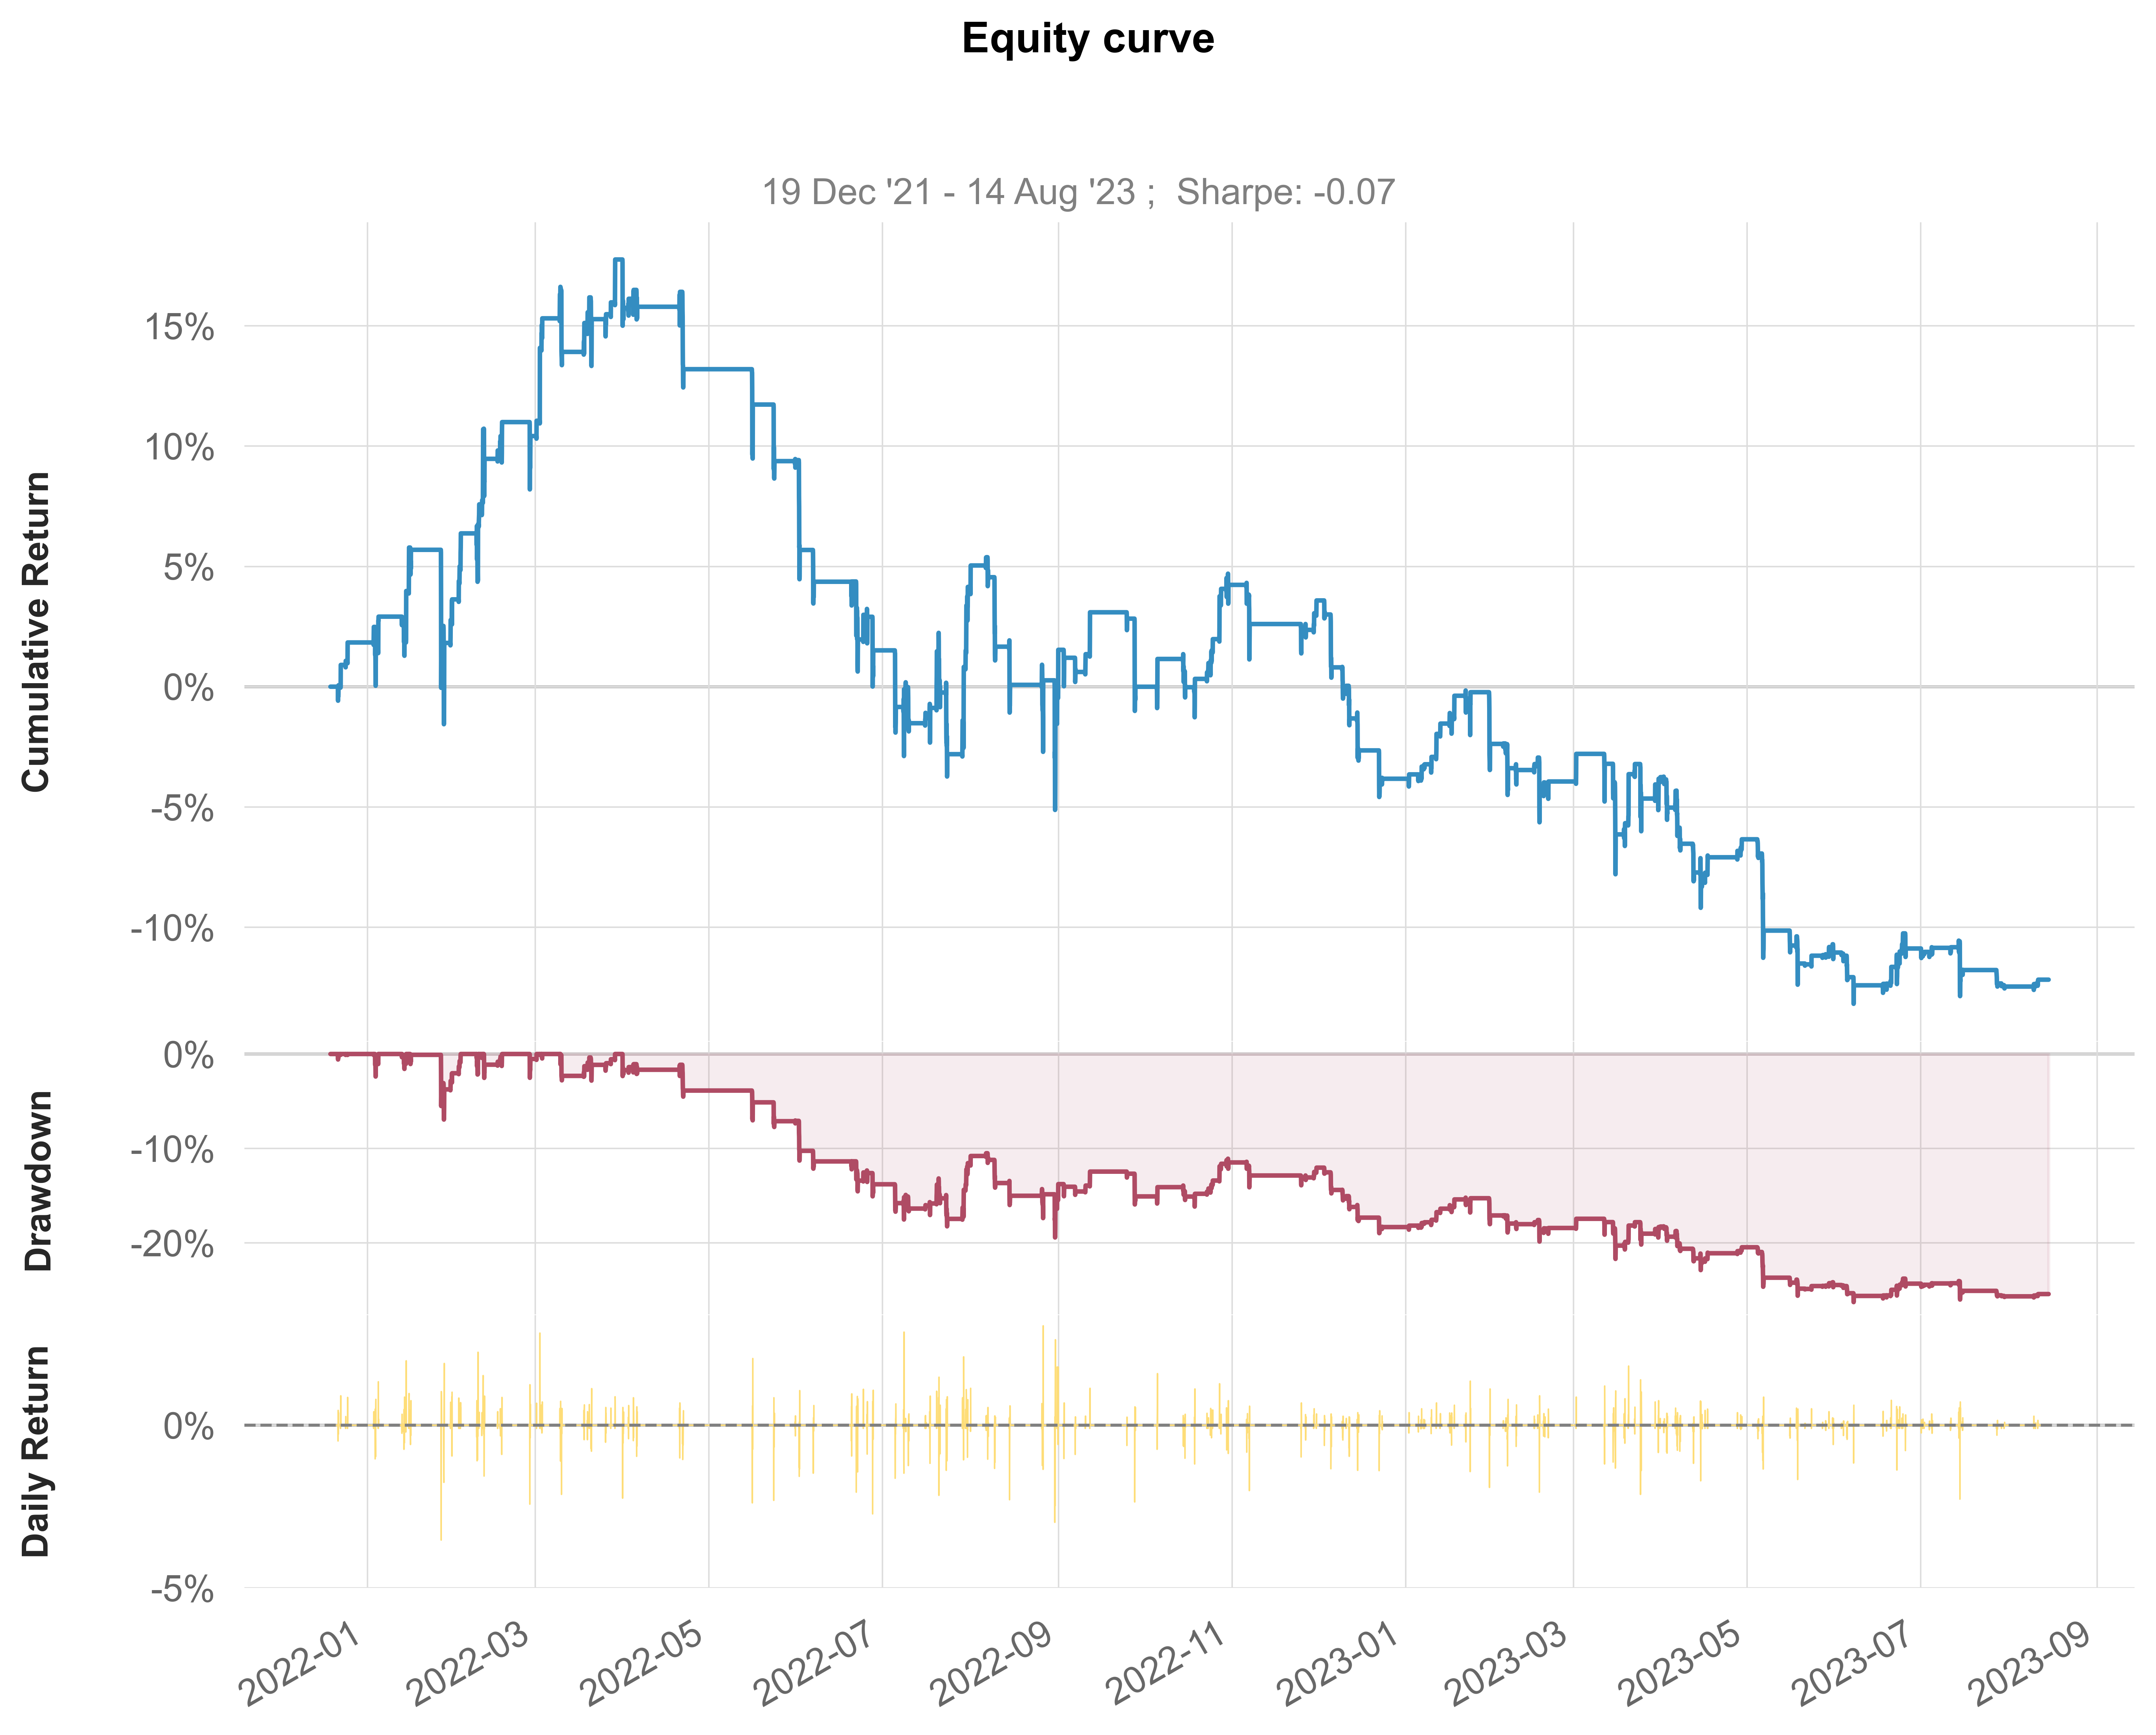

In [6]:
from tradeexecutor.visual.equity_curve import visualise_equity_curve

visualise_equity_curve(returns)

# Entry and exit

In [7]:
from tradeexecutor.analysis.single_pair import expand_entries_and_exits

df = expand_entries_and_exits(state)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(df)

,Entry,Entry mid price,Exit,Exit mid price,PnL,Vol USD,Vol WETH,LP fee USD,Portfolio size
2021-12-21 15:00:00,2021-12-21 15:00:00,3998.153752,2021-12-21 20:00:00,4004.555598,5.940989,19805.940989,4.949811,9.905448,10000.000000
2021-12-22 13:00:00,2021-12-22 13:00:00,3959.561067,2021-12-22 15:00:00,3997.354241,84.554113,19896.317272,5.001025,9.950657,10005.940989
2021-12-24 08:00:00,2021-12-24 08:00:00,4085.040398,2021-12-24 09:00:00,4096.084357,16.995395,19996.175698,4.888372,10.000591,10090.495103
2021-12-25 00:00:00,2021-12-25 00:00:00,4028.653949,2021-12-25 01:00:00,4063.448034,76.334141,20089.165326,4.965140,10.047105,10107.490497
2022-01-03 04:00:00,2022-01-03 04:00:00,3783.068517,2022-01-03 06:00:00,3811.165650,64.727878,20228.700663,5.327394,10.116888,10183.824639
2022-01-03 16:00:00,2022-01-03 16:00:00,3785.717460,2022-01-03 23:00:00,3752.550951,-98.941410,20193.192573,5.357503,10.099109,10248.552517
2022-01-04 19:00:00,2022-01-04 19:00:00,3764.954203,2022-01-04 22:00:00,3821.851333,141.655294,20237.885285,5.335041,10.121491,10149.611106
2022-01-13 02:00:00,2022-01-13 02:00:00,3341.573026,2022-01-13 07:00:00,3338.233290,-20.355837,20356.351636,6.094891,10.180719,10291.266400
2022-01-13 18:00:00,2022-01-13 18:00:00,3277.046754,2022-01-14 01:00:00,3262.660141,-54.758078,20281.644838,6.202609,10.143352,10270.910564
2022-01-14 11:00:00,2022-01-14 11:00:00,3212.481308,2022-01-14 15:00:00,3273.444164,181.631169,20409.613090,6.293538,10.207382,10216.152486
